In [1]:
import os
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
import wandb
from pathlib import Path
import orbax.checkpoint
from flax.training import train_state, orbax_utils
from sklearn.metrics import roc_auc_score, roc_curve, auc
import models
import data_utils
from tqdm import tqdm

api = wandb.Api()
# Project is specified by <entity/project-name>
runs = api.runs("mingfong/fullsim")

In [31]:
# find the epochs with best val AUC to load weights from
runid_to_best_epoch = {}      # {runid: best epoch}

# dataframe for number of epochs needed
d_num_epochs = {
  "num_rows": [],
  "pretrained": [],
  "num_epochs": [],
}

for run in runs:
  # if run.config["seed"] != 1:
  #   continue
  print(run.id, run.name)
  hist = run.history()
  
  best_val_auc = 0
  best_epoch = 0
  for h in run.scan_history(keys=["epoch/epoch", "epoch/val_auc"], page_size=1000000):
    if h["epoch/val_auc"] > best_val_auc:
      best_val_auc = h["epoch/val_auc"]
      best_epoch = h["epoch/epoch"]
  runid_to_best_epoch[run.id] = best_epoch
  print(f"best_epoch = {best_epoch}, best_val_auc = {best_val_auc}")
  d_num_epochs["num_rows"].append(run.config["train_samples"])
  d_num_epochs["pretrained"].append("transfered" in run.name)
  d_num_epochs["num_epochs"].append(best_epoch)
num_epochs_df = pd.DataFrame(d_num_epochs)
agg_num_epochs_df = num_epochs_df.groupby(["num_rows", "pretrained"]).agg(["mean", "std"]).reset_index()

wze56p0x fullsim_only5 8M
best_epoch = 173, best_val_auc = 0.9432830776593978
tz1efo1f fullsim_only3 8M
best_epoch = 199, best_val_auc = 0.9439529154819333
jesvboir fullsim_only4 8M
best_epoch = 130, best_val_auc = 0.9436246840614746
1gug1b8l fullsim_only1 8M
best_epoch = 158, best_val_auc = 0.943757672995876
eudt061a fullsim_only2 8M
best_epoch = 132, best_val_auc = 0.9433773374995754
12jjhepj fullsim_only5 4M
best_epoch = 157, best_val_auc = 0.9381191491068142
y7reyql2 fullsim_only4 4M
best_epoch = 160, best_val_auc = 0.9379160047643385
yp8wtemj fullsim_only2 4M
best_epoch = 136, best_val_auc = 0.9378456373230826
lb2bwgvb fullsim_only3 4M
best_epoch = 163, best_val_auc = 0.9386122932315726
78gic51i fullsim_only1 4M
best_epoch = 159, best_val_auc = 0.9387912707744835
j3juf5w6 fullsim_only5 2M
best_epoch = 190, best_val_auc = 0.9318401674805372
lgik60oy fullsim_only4 2M
best_epoch = 188, best_val_auc = 0.9314918713801077
j6uj0vzt fullsim_only3 2M
best_epoch = 178, best_val_auc = 0.9316

In [32]:
agg_num_epochs_df

num_rows pretrained num_epochs           
                             mean        std
0   2048000      False      188.8  12.477981
1   2048000       True       55.2   5.890671
2   4096000      False      155.0  10.839742
3   4096000       True       58.6   4.827007
4   8192000      False      158.4  29.005172
5   8192000       True       66.6   7.700649
6  16384000      False      215.8  25.684626
7  16384000       True       86.0  17.492856

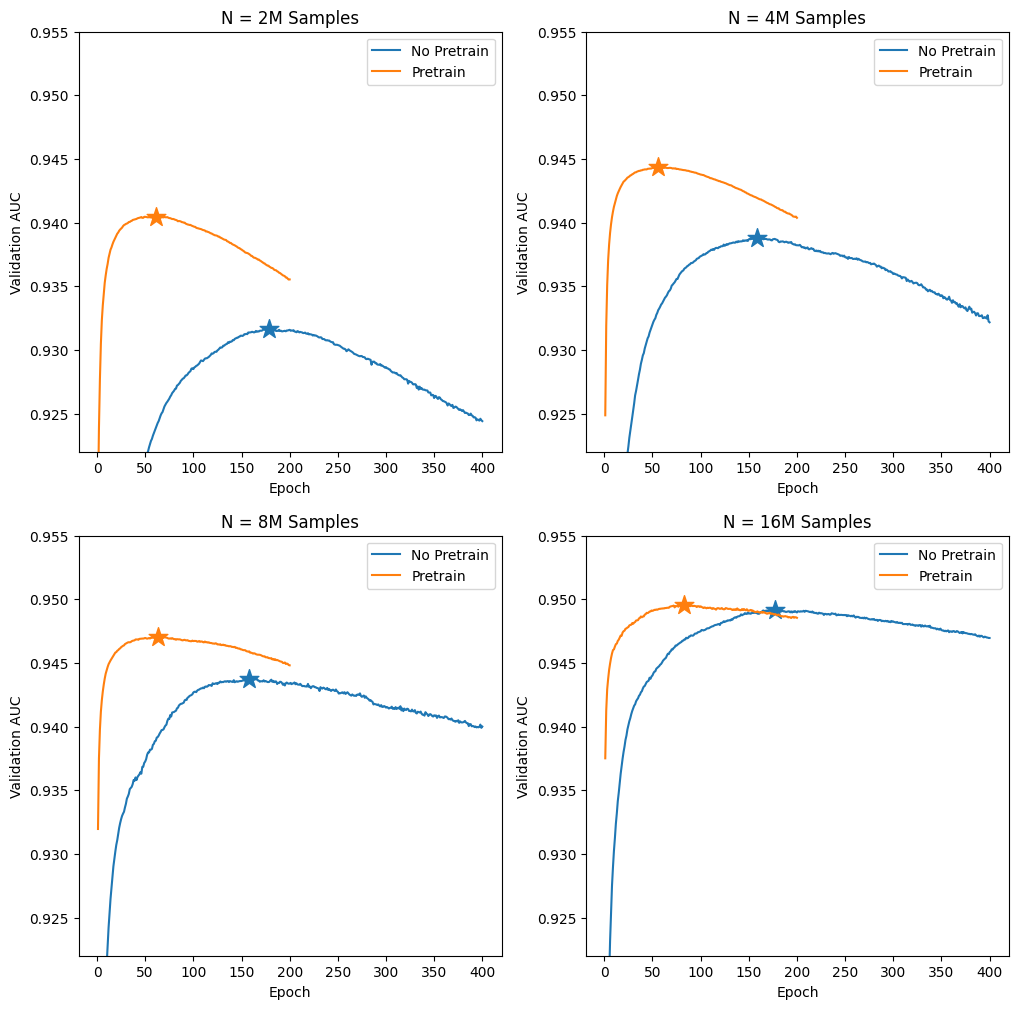

In [3]:
# plot loss curves
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()
NUM_ROWS = [2048000, 4096000, 8192000, 16384000]
for i, num_rows in enumerate(NUM_ROWS):
  for is_pretrained in ["_only", "_transfered"]:
    for run in runs:
      if run.config["train_samples"] != num_rows:
        continue
      if run.config["seed"] != 1:
        continue
      if is_pretrained not in run.name:
        continue
      hist = run.scan_history(keys=["epoch/epoch", "epoch/val_auc"], page_size=1000000)
      hist_df = pd.DataFrame(hist)
      best_epoch = runid_to_best_epoch[run.id]
      color = "C0" if "_only" in run.name else "C1"
      label = "No Pretrain" if "_only" in run.name else "Pretrain"
      axes[i].plot(hist_df["epoch/epoch"], hist_df["epoch/val_auc"], label=label, color=color)
      axes[i].set_title(f"N = {int(num_rows // 1e6)}M Samples")
      # mark the best epoch with a star
      axes[i].scatter(best_epoch, hist_df[hist_df["epoch/epoch"] == best_epoch]["epoch/val_auc"], marker="*", color=color, s=200)
    
for ax in axes:
  ax.set_xlabel("Epoch")
  ax.set_ylabel("Validation AUC")
  ax.set_ylim(0.922, 0.955)
  ax.legend()

## Inference Pipeline on TEST dataset

In [4]:
def init_train_state(rng_key, model, optimizer, batch):
  """Initialize training state."""
  params = model.init(rng_key, batch)
  return train_state.TrainState.create(
      apply_fn=model.apply,
      params=params,
      tx=optimizer)

@jax.jit
def eval_step(
  state: train_state.TrainState,
  batch: jnp.ndarray,
  ):
  """Perform a single evaluation step."""
  x, y = batch
  logits = state.apply_fn(state.params, x).squeeze()
  loss = jnp.mean(optax.sigmoid_binary_cross_entropy(logits=logits, labels=y))
  return loss, logits

In [5]:
def inference_loop(checkpoint_dir: Path, test_dataloader: data_utils.JaxDataLoader, seed: int=1):
  """
  Gets inference predictions for a given checkpoint directory.
  checkpoint_dir example: /pscratch/sd/m/mingfong/transfer-learning/checkpoints/532gak2v/
  Output: y_true, y_pred
  """
  rng = np.random.RandomState(seed)
  rng_key = jax.random.PRNGKey(rng.randint(2**32))
  DNN_LAYERS = [400, 400, 400, 400, 400, 1]
  LEARNING_RATE = 0.0001

  dummy_input = next(iter(test_dataloader))[0]
  print(f"Input shape: {dummy_input.shape}")

  model = models.MLP(features=DNN_LAYERS)
  opt = optax.adam(LEARNING_RATE)
  state = init_train_state(rng_key, model, opt, dummy_input)

  # load checkpoint for params
  ckpt = {
    "step": 0,
    "state": state,
  }
  orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
  # save_args = orbax_utils.save_args_from_target(ckpt)

  # CHECKPOINT_DIR = Path("/pscratch/sd/m/mingfong/transfer-learning/checkpoints/532gak2v/")
  raw_restored = orbax_checkpointer.restore(checkpoint_dir, item=ckpt)
  state = raw_restored["state"]
  # start_step = raw_restored["step"] + 1
  
  test_datagen = iter(test_dataloader)
  test_batch_matrics = {
    "loss": [],
    "accuracy": [],
    "auc": [],
  }
  logits_list = []
  y_true_list = []

  for batch_step in tqdm(range(len(test_dataloader))):
    batch = next(test_datagen)
    loss, logits = eval_step(state, batch)
    test_batch_matrics["loss"].append(loss)
    test_batch_matrics["accuracy"].append(jnp.mean((logits > 0) == batch[1]))
    test_batch_matrics["auc"].append(roc_auc_score(batch[1], logits))
    logits_list.append(logits)
    y_true_list.append(batch[1])
    
  y_true = np.concatenate(y_true_list)
  y_pred = np.concatenate(logits_list)
  print(f"y_true: {y_true.shape}")
  print(f"y_pred: {y_pred.shape}")
  return y_true, y_pred

In [6]:
# testing data loading
BATCH_SIZE = 1024
MAX_ROWS = None # None for all

test_dir_preprocess = "/pscratch/sd/m/mingfong/transfer-learning/fullsim_test_processed/"
test_preprocess_file_names = os.listdir(test_dir_preprocess)
test_preprocess_filepaths = [test_dir_preprocess + name for name in test_preprocess_file_names]

DatasetClassToUse = data_utils.H5DatasetLoadAll

test_dataset = DatasetClassToUse(test_preprocess_filepaths, max_rows=MAX_ROWS, reverse_data=True)
test_dataloader = data_utils.JaxDataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(f"Num val samples: {len(test_dataset)}")

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:33<?, ?it/s]

Num val samples: 2484117


In [7]:
CHECKPOINT_DOWNLOAD_DIR = Path("/pscratch/sd/m/mingfong/transfer-learning/checkpoints/")
output_dict = {} # {run_id: (y_true, y_pred)}

for run in runs:
  # if run.config["seed"] != 1:
  #   continue
  print(f"{run.name}: {run.id} (seed: {run.config['seed']})")
  best_epoch = (runid_to_best_epoch[run.id] // 10) - 1     # we only save checkpoints every 10 epochs
  print("Downloading artifact ")
  artifact = api.artifact(f"mingfong/fullsim/{run.id}-checkpoint:v{best_epoch}")
  artifact_path = CHECKPOINT_DOWNLOAD_DIR / run.id
  artifact.download(artifact_path)
  print(f"Downloaded {run.id} to {artifact_path}")
  output_dict[run.id] = inference_loop(artifact_path, test_dataloader, seed=run.config["seed"])

fullsim_only5 8M: wze56p0x (seed: 5)


wandb:   1 of 1 files downloaded.  


Downloaded wze56p0x to /pscratch/sd/m/mingfong/transfer-learning/checkpoints/wze56p0x


2024-05-04 00:37:20.009833: W external/xla/xla/service/platform_util.cc:198] unable to create StreamExecutor for CUDA:0: failed initializing StreamExecutor for CUDA device ordinal 0: INTERNAL: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_OUT_OF_MEMORY: out of memory; total memory reported: 42297524224


Input shape: (1024, 1400)


100%|██████████| 2426/2426 [00:49<00:00, 48.74it/s]


y_true: (2484117,)
y_pred: (2484117,)
fullsim_only3 8M: tz1efo1f (seed: 3)


wandb:   1 of 1 files downloaded.  


Downloaded tz1efo1f to /pscratch/sd/m/mingfong/transfer-learning/checkpoints/tz1efo1f
Input shape: (1024, 1400)


100%|██████████| 2426/2426 [00:49<00:00, 48.68it/s]


y_true: (2484117,)
y_pred: (2484117,)
fullsim_only4 8M: jesvboir (seed: 4)


wandb:   1 of 1 files downloaded.  


Downloaded jesvboir to /pscratch/sd/m/mingfong/transfer-learning/checkpoints/jesvboir
Input shape: (1024, 1400)


100%|██████████| 2426/2426 [00:50<00:00, 47.68it/s]


y_true: (2484117,)
y_pred: (2484117,)
fullsim_only1 8M: 1gug1b8l (seed: 1)


wandb:   1 of 1 files downloaded.  


Downloaded 1gug1b8l to /pscratch/sd/m/mingfong/transfer-learning/checkpoints/1gug1b8l
Input shape: (1024, 1400)


100%|██████████| 2426/2426 [00:50<00:00, 47.61it/s]


y_true: (2484117,)
y_pred: (2484117,)
fullsim_only2 8M: eudt061a (seed: 2)


wandb:   1 of 1 files downloaded.  


Downloaded eudt061a to /pscratch/sd/m/mingfong/transfer-learning/checkpoints/eudt061a
Input shape: (1024, 1400)


100%|██████████| 2426/2426 [00:52<00:00, 46.03it/s]


y_true: (2484117,)
y_pred: (2484117,)
fullsim_only5 4M: 12jjhepj (seed: 5)


wandb:   1 of 1 files downloaded.  


Downloaded 12jjhepj to /pscratch/sd/m/mingfong/transfer-learning/checkpoints/12jjhepj
Input shape: (1024, 1400)


100%|██████████| 2426/2426 [00:51<00:00, 46.98it/s]


y_true: (2484117,)
y_pred: (2484117,)
fullsim_only4 4M: y7reyql2 (seed: 4)


wandb:   1 of 1 files downloaded.  


Downloaded y7reyql2 to /pscratch/sd/m/mingfong/transfer-learning/checkpoints/y7reyql2
Input shape: (1024, 1400)


100%|██████████| 2426/2426 [00:56<00:00, 43.25it/s]


y_true: (2484117,)
y_pred: (2484117,)
fullsim_only2 4M: yp8wtemj (seed: 2)


wandb:   1 of 1 files downloaded.  


Downloaded yp8wtemj to /pscratch/sd/m/mingfong/transfer-learning/checkpoints/yp8wtemj
Input shape: (1024, 1400)


100%|██████████| 2426/2426 [00:52<00:00, 46.13it/s]


y_true: (2484117,)
y_pred: (2484117,)
fullsim_only3 4M: lb2bwgvb (seed: 3)


wandb:   1 of 1 files downloaded.  


Downloaded lb2bwgvb to /pscratch/sd/m/mingfong/transfer-learning/checkpoints/lb2bwgvb
Input shape: (1024, 1400)


100%|██████████| 2426/2426 [00:51<00:00, 47.06it/s]


y_true: (2484117,)
y_pred: (2484117,)
fullsim_only1 4M: 78gic51i (seed: 1)


wandb:   1 of 1 files downloaded.  


Downloaded 78gic51i to /pscratch/sd/m/mingfong/transfer-learning/checkpoints/78gic51i
Input shape: (1024, 1400)


100%|██████████| 2426/2426 [00:50<00:00, 47.85it/s]


y_true: (2484117,)
y_pred: (2484117,)
fullsim_only5 2M: j3juf5w6 (seed: 5)


wandb:   1 of 1 files downloaded.  


Downloaded j3juf5w6 to /pscratch/sd/m/mingfong/transfer-learning/checkpoints/j3juf5w6
Input shape: (1024, 1400)


100%|██████████| 2426/2426 [00:51<00:00, 46.84it/s]


y_true: (2484117,)
y_pred: (2484117,)
fullsim_only4 2M: lgik60oy (seed: 4)


wandb:   1 of 1 files downloaded.  


Downloaded lgik60oy to /pscratch/sd/m/mingfong/transfer-learning/checkpoints/lgik60oy
Input shape: (1024, 1400)


100%|██████████| 2426/2426 [00:52<00:00, 46.46it/s]


y_true: (2484117,)
y_pred: (2484117,)
fullsim_only3 2M: j6uj0vzt (seed: 3)


wandb:   1 of 1 files downloaded.  


Downloaded j6uj0vzt to /pscratch/sd/m/mingfong/transfer-learning/checkpoints/j6uj0vzt
Input shape: (1024, 1400)


100%|██████████| 2426/2426 [00:55<00:00, 43.97it/s]


y_true: (2484117,)
y_pred: (2484117,)
fullsim_only2 2M: 4ruo9o21 (seed: 2)


wandb:   1 of 1 files downloaded.  


Downloaded 4ruo9o21 to /pscratch/sd/m/mingfong/transfer-learning/checkpoints/4ruo9o21
Input shape: (1024, 1400)


100%|██████████| 2426/2426 [00:54<00:00, 44.69it/s]


y_true: (2484117,)
y_pred: (2484117,)
fullsim_only1 2M: 1j31rso6 (seed: 1)


wandb:   1 of 1 files downloaded.  


Downloaded 1j31rso6 to /pscratch/sd/m/mingfong/transfer-learning/checkpoints/1j31rso6
Input shape: (1024, 1400)


100%|██████████| 2426/2426 [00:52<00:00, 45.91it/s]


y_true: (2484117,)
y_pred: (2484117,)
fullsim_transfered5 16M: 532gak2v (seed: 5)


wandb:   1 of 1 files downloaded.  


Downloaded 532gak2v to /pscratch/sd/m/mingfong/transfer-learning/checkpoints/532gak2v
Input shape: (1024, 1400)


100%|██████████| 2426/2426 [00:50<00:00, 47.88it/s]


y_true: (2484117,)
y_pred: (2484117,)
fullsim_transfered5 8M: veyvse59 (seed: 5)


wandb:   1 of 1 files downloaded.  


Downloaded veyvse59 to /pscratch/sd/m/mingfong/transfer-learning/checkpoints/veyvse59
Input shape: (1024, 1400)


100%|██████████| 2426/2426 [00:53<00:00, 45.64it/s]


y_true: (2484117,)
y_pred: (2484117,)
fullsim_transfered4 16M: b483kdg6 (seed: 4)


wandb:   1 of 1 files downloaded.  


Downloaded b483kdg6 to /pscratch/sd/m/mingfong/transfer-learning/checkpoints/b483kdg6
Input shape: (1024, 1400)


100%|██████████| 2426/2426 [01:03<00:00, 38.27it/s]


y_true: (2484117,)
y_pred: (2484117,)
fullsim_transfered4 8M: f7otgiky (seed: 4)


wandb:   1 of 1 files downloaded.  


Downloaded f7otgiky to /pscratch/sd/m/mingfong/transfer-learning/checkpoints/f7otgiky
Input shape: (1024, 1400)


100%|██████████| 2426/2426 [00:54<00:00, 44.20it/s]


y_true: (2484117,)
y_pred: (2484117,)
fullsim_transfered3 16M: yhexvltv (seed: 3)


wandb:   1 of 1 files downloaded.  


Downloaded yhexvltv to /pscratch/sd/m/mingfong/transfer-learning/checkpoints/yhexvltv
Input shape: (1024, 1400)


100%|██████████| 2426/2426 [00:47<00:00, 51.51it/s]


y_true: (2484117,)
y_pred: (2484117,)
fullsim_transfered3 8M: xwb9lvdo (seed: 3)


wandb:   1 of 1 files downloaded.  


Downloaded xwb9lvdo to /pscratch/sd/m/mingfong/transfer-learning/checkpoints/xwb9lvdo
Input shape: (1024, 1400)


100%|██████████| 2426/2426 [00:57<00:00, 42.43it/s]


y_true: (2484117,)
y_pred: (2484117,)
fullsim_transfered2 16M: 6rgky02g (seed: 2)


wandb:   1 of 1 files downloaded.  


Downloaded 6rgky02g to /pscratch/sd/m/mingfong/transfer-learning/checkpoints/6rgky02g
Input shape: (1024, 1400)


100%|██████████| 2426/2426 [00:46<00:00, 52.55it/s]


y_true: (2484117,)
y_pred: (2484117,)
fullsim_transfered2 8M: wtq686zk (seed: 2)


wandb:   1 of 1 files downloaded.  


Downloaded wtq686zk to /pscratch/sd/m/mingfong/transfer-learning/checkpoints/wtq686zk
Input shape: (1024, 1400)


100%|██████████| 2426/2426 [01:03<00:00, 38.05it/s]


y_true: (2484117,)
y_pred: (2484117,)
fullsim_transfered1 16M: 4rqwunj6 (seed: 1)


wandb:   1 of 1 files downloaded.  


Downloaded 4rqwunj6 to /pscratch/sd/m/mingfong/transfer-learning/checkpoints/4rqwunj6
Input shape: (1024, 1400)


100%|██████████| 2426/2426 [00:52<00:00, 46.09it/s]


y_true: (2484117,)
y_pred: (2484117,)
fullsim_transfered1 8M: gb736s9n (seed: 1)


wandb:   1 of 1 files downloaded.  


Downloaded gb736s9n to /pscratch/sd/m/mingfong/transfer-learning/checkpoints/gb736s9n
Input shape: (1024, 1400)


100%|██████████| 2426/2426 [00:54<00:00, 44.58it/s]


y_true: (2484117,)
y_pred: (2484117,)
fullsim_transfered3 2M: 0ib37wsb (seed: 3)


wandb:   1 of 1 files downloaded.  


Downloaded 0ib37wsb to /pscratch/sd/m/mingfong/transfer-learning/checkpoints/0ib37wsb
Input shape: (1024, 1400)


100%|██████████| 2426/2426 [00:53<00:00, 45.17it/s]


y_true: (2484117,)
y_pred: (2484117,)
fullsim_transfered3 4M: btda5j3c (seed: 3)


wandb:   1 of 1 files downloaded.  


Downloaded btda5j3c to /pscratch/sd/m/mingfong/transfer-learning/checkpoints/btda5j3c
Input shape: (1024, 1400)


100%|██████████| 2426/2426 [00:51<00:00, 46.98it/s]


y_true: (2484117,)
y_pred: (2484117,)
fullsim_transfered1 4M: a2ypm3lr (seed: 1)


wandb:   1 of 1 files downloaded.  


Downloaded a2ypm3lr to /pscratch/sd/m/mingfong/transfer-learning/checkpoints/a2ypm3lr
Input shape: (1024, 1400)


100%|██████████| 2426/2426 [00:54<00:00, 44.72it/s]


y_true: (2484117,)
y_pred: (2484117,)
fullsim_transfered1 2M: co3u843s (seed: 1)


wandb:   1 of 1 files downloaded.  


Downloaded co3u843s to /pscratch/sd/m/mingfong/transfer-learning/checkpoints/co3u843s
Input shape: (1024, 1400)


100%|██████████| 2426/2426 [00:50<00:00, 48.05it/s]


y_true: (2484117,)
y_pred: (2484117,)
fullsim_transfered 4M: 8scyomvw (seed: 5)


wandb:   1 of 1 files downloaded.  


Downloaded 8scyomvw to /pscratch/sd/m/mingfong/transfer-learning/checkpoints/8scyomvw
Input shape: (1024, 1400)


100%|██████████| 2426/2426 [00:53<00:00, 44.97it/s]


y_true: (2484117,)
y_pred: (2484117,)
fullsim_transfered 2M: mwbrtifb (seed: 5)


wandb:   1 of 1 files downloaded.  


Downloaded mwbrtifb to /pscratch/sd/m/mingfong/transfer-learning/checkpoints/mwbrtifb
Input shape: (1024, 1400)


100%|██████████| 2426/2426 [00:54<00:00, 44.27it/s]


y_true: (2484117,)
y_pred: (2484117,)
fullsim_transfered 4M: afpv10i8 (seed: 4)


wandb:   1 of 1 files downloaded.  


Downloaded afpv10i8 to /pscratch/sd/m/mingfong/transfer-learning/checkpoints/afpv10i8
Input shape: (1024, 1400)


100%|██████████| 2426/2426 [00:54<00:00, 44.41it/s]


y_true: (2484117,)
y_pred: (2484117,)
fullsim_transfered 2M: 8kv2yvi0 (seed: 4)


wandb:   1 of 1 files downloaded.  


Downloaded 8kv2yvi0 to /pscratch/sd/m/mingfong/transfer-learning/checkpoints/8kv2yvi0
Input shape: (1024, 1400)


100%|██████████| 2426/2426 [00:50<00:00, 47.63it/s]


y_true: (2484117,)
y_pred: (2484117,)
fullsim_transfered 2M: 79ka8j6l (seed: 2)


wandb:   1 of 1 files downloaded.  


Downloaded 79ka8j6l to /pscratch/sd/m/mingfong/transfer-learning/checkpoints/79ka8j6l
Input shape: (1024, 1400)


100%|██████████| 2426/2426 [00:56<00:00, 43.02it/s]


y_true: (2484117,)
y_pred: (2484117,)
fullsim_transfered 4M: oobw6u19 (seed: 2)


wandb:   1 of 1 files downloaded.  


Downloaded oobw6u19 to /pscratch/sd/m/mingfong/transfer-learning/checkpoints/oobw6u19
Input shape: (1024, 1400)


100%|██████████| 2426/2426 [00:50<00:00, 48.02it/s]


y_true: (2484117,)
y_pred: (2484117,)
fullsim_only5 16M: 25ao9xre (seed: 5)


wandb:   1 of 1 files downloaded.  


Downloaded 25ao9xre to /pscratch/sd/m/mingfong/transfer-learning/checkpoints/25ao9xre
Input shape: (1024, 1400)


100%|██████████| 2426/2426 [00:50<00:00, 47.89it/s]


y_true: (2484117,)
y_pred: (2484117,)
fullsim_only3 16M: wl0uyh35 (seed: 3)


wandb:   1 of 1 files downloaded.  


Downloaded wl0uyh35 to /pscratch/sd/m/mingfong/transfer-learning/checkpoints/wl0uyh35
Input shape: (1024, 1400)


100%|██████████| 2426/2426 [00:51<00:00, 47.14it/s]


y_true: (2484117,)
y_pred: (2484117,)
fullsim_only4 16M: ao7s8qoe (seed: 4)


wandb:   1 of 1 files downloaded.  


Downloaded ao7s8qoe to /pscratch/sd/m/mingfong/transfer-learning/checkpoints/ao7s8qoe
Input shape: (1024, 1400)


100%|██████████| 2426/2426 [00:52<00:00, 45.87it/s]


y_true: (2484117,)
y_pred: (2484117,)
fullsim_only2 16M: ulw1w4nn (seed: 2)


wandb:   1 of 1 files downloaded.  


Downloaded ulw1w4nn to /pscratch/sd/m/mingfong/transfer-learning/checkpoints/ulw1w4nn
Input shape: (1024, 1400)


100%|██████████| 2426/2426 [00:56<00:00, 42.75it/s]


y_true: (2484117,)
y_pred: (2484117,)
fullsim_only1 16M: ujrwfssb (seed: 1)


wandb:   1 of 1 files downloaded.  


Downloaded ujrwfssb to /pscratch/sd/m/mingfong/transfer-learning/checkpoints/ujrwfssb
Input shape: (1024, 1400)


100%|██████████| 2426/2426 [00:54<00:00, 44.89it/s]

y_true: (2484117,)
y_pred: (2484117,)


In [8]:
# auc values for all runs
NUM_ROWS = [2048000, 4096000, 8192000, 16384000]
auc_dict = {
  "train_samples": [],
  "transfered": [],
  "auc": [],
  "acc": [],
  }
for num_rows in NUM_ROWS:
  for run in runs:
    if run.config["train_samples"] != num_rows:
      continue
    
    auc_dict["transfered"].append("transfered" in run.name)
    auc_dict["train_samples"].append(num_rows)
    y_true, y_pred = output_dict[run.id]
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    auc_dict["auc"].append(roc_auc)
    acc = np.mean((y_pred > 0) == y_true)
    auc_dict["acc"].append(acc)
    print(f"{run.name}: AUC: {roc_auc:0.5f}, ACC:{acc:0.5f}, transfered: {'transfered' in run.name}, train_samples: {num_rows}")
auc_df = pd.DataFrame(auc_dict)

fullsim_only5 2M: AUC: 0.92803, ACC:0.84904, transfered: False, train_samples: 2048000
fullsim_only4 2M: AUC: 0.92794, ACC:0.84913, transfered: False, train_samples: 2048000
fullsim_only3 2M: AUC: 0.92750, ACC:0.84870, transfered: False, train_samples: 2048000
fullsim_only2 2M: AUC: 0.92906, ACC:0.85035, transfered: False, train_samples: 2048000
fullsim_only1 2M: AUC: 0.92719, ACC:0.84829, transfered: False, train_samples: 2048000
fullsim_transfered3 2M: AUC: 0.94266, ACC:0.86876, transfered: True, train_samples: 2048000
fullsim_transfered1 2M: AUC: 0.94022, ACC:0.86573, transfered: True, train_samples: 2048000
fullsim_transfered 2M: AUC: 0.94111, ACC:0.86682, transfered: True, train_samples: 2048000
fullsim_transfered 2M: AUC: 0.94111, ACC:0.86682, transfered: True, train_samples: 2048000
fullsim_transfered 2M: AUC: 0.94038, ACC:0.86595, transfered: True, train_samples: 2048000
fullsim_only5 4M: AUC: 0.93493, ACC:0.85774, transfered: False, train_samples: 4096000
fullsim_only4 4M: AUC

In [9]:
agg_auc_df = auc_df.groupby(["train_samples", "transfered"]).mean().reset_index()
agg_auc_df = agg_auc_df.rename(columns={"auc": "mean_auc", "acc": "mean_acc"})
agg_auc_df["std_auc"] = auc_df.groupby(["train_samples", "transfered"]).std().reset_index()["auc"]
agg_auc_df["std_acc"] = auc_df.groupby(["train_samples", "transfered"]).std().reset_index()["acc"]
agg_auc_df

,train_samples,transfered,mean_auc,mean_acc,std_auc,std_acc
0,2048000,False,0.927945,0.849100,0.000708,0.000773
1,2048000,True,0.941095,0.866816,0.000965,0.001195
2,4096000,False,0.934979,0.857626,0.000595,0.001009
3,4096000,True,0.945218,0.871539,0.000749,0.000994
4,8192000,False,0.940586,0.865166,0.001197,0.001645
5,8192000,True,0.947796,0.874859,0.000596,0.001024
6,16384000,False,0.948935,0.876785,0.000403,0.000604
7,16384000,True,0.949952,0.878031,0.000437,0.000622


1gug1b8l
roc_auc = 0.9405723942387091
78gic51i
roc_auc = 0.9355153283778953
1j31rso6
roc_auc = 0.9271947961009762
4rqwunj6
roc_auc = 0.94957390404888
gb736s9n
roc_auc = 0.946971729089269
a2ypm3lr
roc_auc = 0.9442912630524615
co3u843s
roc_auc = 0.9402156449824206
ujrwfssb
roc_auc = 0.94900596947679


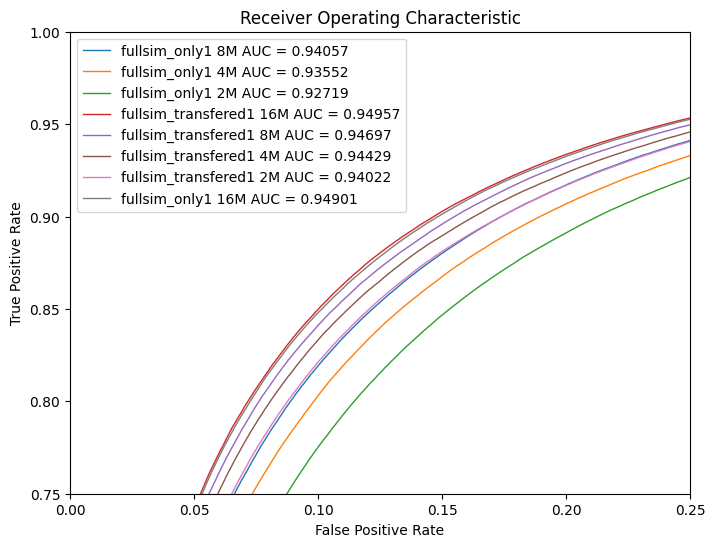

In [11]:
plt.figure(figsize=(8,6))
for run in runs:
  if run.config["seed"] != 1:
    continue
  if run.id not in output_dict:
    continue
  print(run.id)
  y_true, y_pred = output_dict[run.id]
  fpr, tpr, thresholds = roc_curve(y_true, y_pred)
  roc_auc = auc(fpr, tpr)
  print(f"roc_auc = {roc_auc}")
  plt.plot(fpr, tpr, label = f'{run.name} AUC = %0.5f' % roc_auc, linewidth=1.0)
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'upper left')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 0.25])
plt.ylim([0.75, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

fullsim_only1 2M: 1j31rso6 (seed: 1)
roc_auc = 0.9271947961009762
fullsim_transfered1 2M: co3u843s (seed: 1)
roc_auc = 0.9402156449824206
fullsim_only1 4M: 78gic51i (seed: 1)
roc_auc = 0.9355153283778953
fullsim_transfered1 4M: a2ypm3lr (seed: 1)
roc_auc = 0.9442912630524615
fullsim_only1 8M: 1gug1b8l (seed: 1)
roc_auc = 0.9405723942387091
fullsim_transfered1 8M: gb736s9n (seed: 1)
roc_auc = 0.946971729089269
fullsim_only1 16M: ujrwfssb (seed: 1)
roc_auc = 0.94900596947679
fullsim_transfered1 16M: 4rqwunj6 (seed: 1)
roc_auc = 0.94957390404888


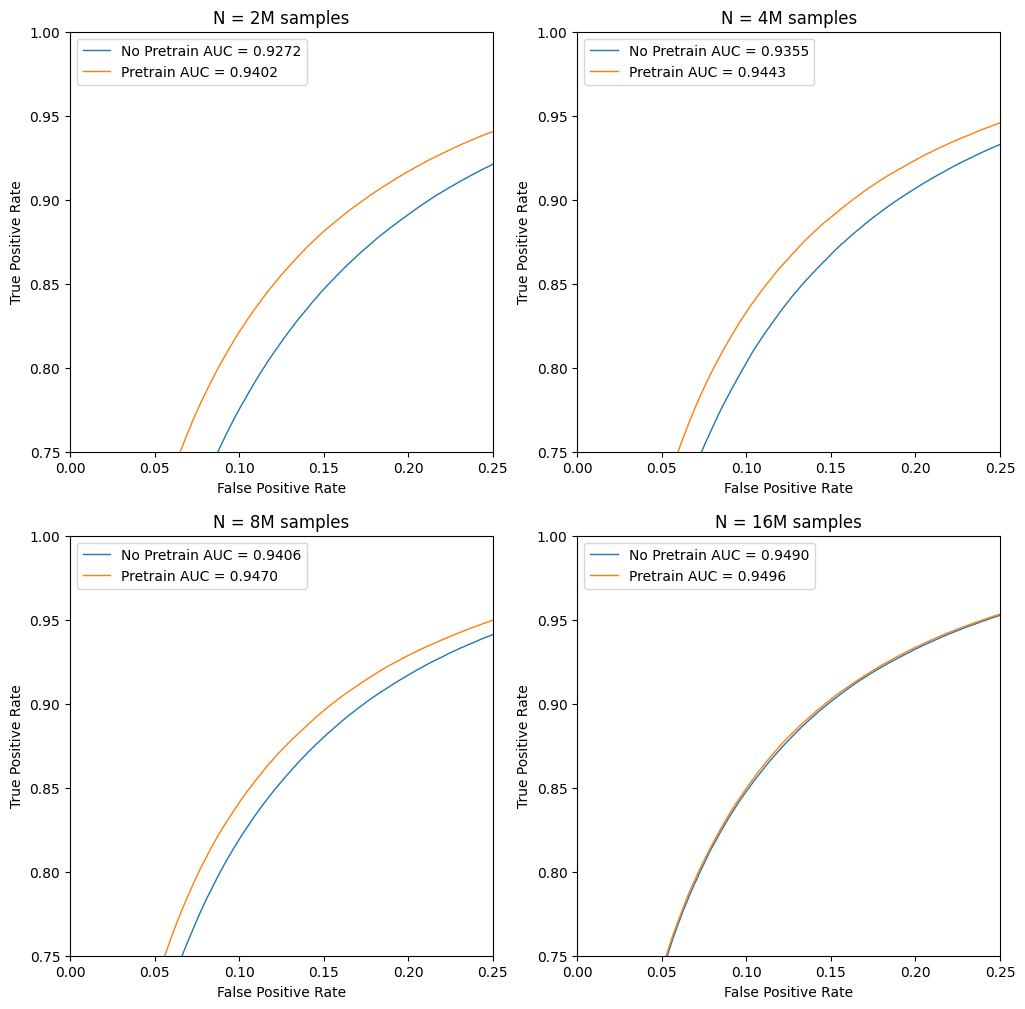

In [12]:
# 2x2 plot
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

# sperate plots for each num rows
for i, num_rows in enumerate(NUM_ROWS):
  for is_pretrained in ["_only", "_transfered"]:
    for run in runs:
      if run.config["seed"] != 1:
        continue
      if run.config["train_samples"] != num_rows:
        continue
      if is_pretrained not in run.name:
        continue
      print(f"{run.name}: {run.id} (seed: {run.config['seed']})")
      y_true, y_pred = output_dict[run.id]
      fpr, tpr, thresholds = roc_curve(y_true, y_pred)
      roc_auc = auc(fpr, tpr)
      print(f"roc_auc = {roc_auc}")
      curr_label = "Pretrain" if "transfered" in run.name else "No Pretrain"
      color = "C1" if "transfered" in run.name else "C0"
      axes[i].plot(fpr, tpr, label = f"{curr_label} AUC = {roc_auc:0.4f}", linewidth=1.0, color=color)
      axes[i].set_title(f"N = {int(num_rows // 1e6)}M samples")
      axes[i].legend(loc = "upper left")
      axes[i].plot([0, 1], [0, 1],'r--')
      axes[i].set_xlim([0, 0.25])
      axes[i].set_ylim([0.75, 1])
      axes[i].set_ylabel('True Positive Rate')
      axes[i].set_xlabel('False Positive Rate')
plt.show()

fullsim_only1 2M
fullsim_transfered1 2M
fullsim_only1 4M
fullsim_transfered1 4M
fullsim_only1 8M
fullsim_transfered1 8M
fullsim_only1 16M
fullsim_transfered1 16M


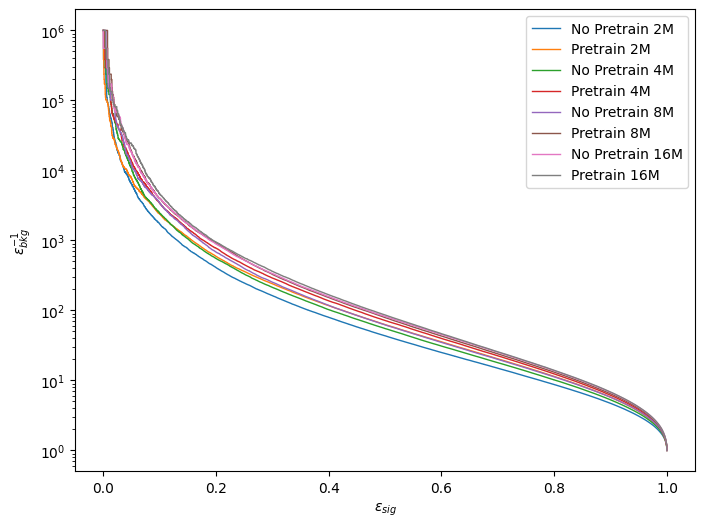

In [18]:
# log(1/fpr) on y
# tpr on x axis
EPS = 1e-6

plt.figure(figsize=(8,6))
for num_rows in NUM_ROWS:
  for is_pretrained in ["_only", "_transfered"]:
    for run in runs:
      if run.config["seed"] != 1:
        continue
      if run.id not in output_dict:
        continue
      if run.config["train_samples"] != num_rows:
        continue
      if is_pretrained not in run.name:
        continue
      # print(run.id)
      y_true, y_pred = output_dict[run.id]
      fpr, tpr, thresholds = roc_curve(y_true, y_pred)
      roc_auc = auc(fpr, tpr)
      # print(roc_auc)
      print(run.name)
      label = "Pretrain" if "transfered" in run.name else "No Pretrain"
      label += f" {int(num_rows // 1e6)}M"
      plt.plot(tpr, (1 / (fpr + EPS)), label = label, linewidth=1.0)
# plt.title("Performance")
plt.legend()
plt.ylabel(r"$\epsilon_{bkg}^{-1}$")
plt.xlabel(r"$\epsilon_{sig}$")
plt.yscale("log")
plt.show()

In [30]:
fixed_tpr = 0.5
plt.figure(figsize=(8,6))

d_50pct = {
  "num_rows": [],
  "pretrained": [],
  "1/fpr": [],
  "tpr": [],
  "fpr": [],
}
for run in tqdm(runs):
  if run.id not in output_dict:
    continue
  y_true, y_pred = output_dict[run.id]
  fpr, tpr, thresholds = roc_curve(y_true, y_pred)
  roc_auc = auc(fpr, tpr)
  idx = np.argmin((tpr - fixed_tpr)**2)
  d_50pct["num_rows"].append(run.config["train_samples"])
  d_50pct["pretrained"].append("transfered" in run.name)
  d_50pct["1/fpr"].append(1 / (fpr[idx]))
  d_50pct["tpr"].append(tpr[idx])
  d_50pct["fpr"].append(fpr[idx])
df_50pct = pd.DataFrame(d_50pct)
agg_df_50pct = df_50pct.groupby(["num_rows", "pretrained"]).mean().reset_index()
agg_df_50pct["fpr_std"] = df_50pct.groupby(["num_rows", "pretrained"]).std().reset_index()["fpr"]
agg_df_50pct["1/fpr_std"] = df_50pct.groupby(["num_rows", "pretrained"]).std().reset_index()["1/fpr"]
agg_df_50pct

100%|██████████| 40/40 [00:21<00:00,  1.85it/s]


,num_rows,pretrained,1/fpr,tpr,fpr,fpr_std,1/fpr_std
0,2048000,False,43.789977,0.500001,0.022841,0.000345,0.674232
1,2048000,True,63.889580,0.500001,0.015662,0.000438,1.840605
2,4096000,False,54.160011,0.499999,0.018468,0.000310,0.905664
3,4096000,True,73.377788,0.499998,0.013634,0.000316,1.730252
4,8192000,False,62.791902,0.500001,0.015948,0.000661,2.624956
5,8192000,True,80.283489,0.500002,0.012458,0.000169,1.086569
6,16384000,False,81.186191,0.500001,0.012323,0.000289,1.926545
7,16384000,True,86.812068,0.499998,0.011523,0.000225,1.707771


<Figure size 800x600 with 0 Axes>

In [29]:
fixed_tpr = 0.8
plt.figure(figsize=(8,6))

d_80pct = {
  "num_rows": [],
  "pretrained": [],
  "1/fpr": [],
  "tpr": [],
  "fpr": [],
}
for run in tqdm(runs):
  if run.id not in output_dict:
    continue
  y_true, y_pred = output_dict[run.id]
  fpr, tpr, thresholds = roc_curve(y_true, y_pred)
  roc_auc = auc(fpr, tpr)
  idx = np.argmin((tpr - fixed_tpr)**2)
  d_80pct["num_rows"].append(run.config["train_samples"])
  d_80pct["pretrained"].append("transfered" in run.name)
  d_80pct["1/fpr"].append(1 / (fpr[idx]))
  d_80pct["tpr"].append(tpr[idx])
  d_80pct["fpr"].append(fpr[idx])
df_80pct = pd.DataFrame(d_80pct)
agg_df_80pct = df_80pct.groupby(["num_rows", "pretrained"]).mean().reset_index()
agg_df_80pct["fpr_std"] = df_80pct.groupby(["num_rows", "pretrained"]).std().reset_index()["fpr"]
agg_df_80pct["1/fpr_std"] = df_80pct.groupby(["num_rows", "pretrained"]).std().reset_index()["1/fpr"]
agg_df_80pct

100%|██████████| 40/40 [00:21<00:00,  1.83it/s]


,num_rows,pretrained,1/fpr,tpr,fpr,fpr_std,1/fpr_std
0,2048000,False,8.838899,0.800000,0.113150,0.001395,0.109969
1,2048000,True,11.626117,0.800000,0.086045,0.001826,0.251558
2,4096000,False,10.050140,0.800000,0.099516,0.001353,0.136127
3,4096000,True,12.659747,0.799999,0.079009,0.001349,0.216659
4,8192000,False,11.267552,0.800001,0.088802,0.002402,0.305025
5,8192000,True,13.403085,0.799999,0.074623,0.001119,0.200240
6,16384000,False,13.768409,0.800000,0.072636,0.000739,0.140266
7,16384000,True,14.099395,0.800000,0.070932,0.000778,0.156085


<Figure size 800x600 with 0 Axes>

In [16]:
# make a plot for training speed
# baseline vs pretrained
# use all fastsim data and see if we can pump performance even more

# work on GNN first pass try